In [1]:
%matplotlib inline
%autoreload 2 

In [2]:
from __future__ import (division, absolute_import,
                        print_function, unicode_literals)
from IPython.html.widgets import interact

:0: FutureWarning: IPython widgets are experimental and may change in the future.


approx mag. of error = Condition number * machine_precision

there are several things that can change the behavior of the covariance kernel
* sampling of data points
* $\beta$ 
* lambda but lambda is degenerate with $\beta$


# What to explore

* is sorting coordinates is going to improve condition number for random coordinates?
* is having a grid like / random sampling scheme going to give us matrix with a smaller condition number? 


In [3]:
import george
import pandas as pd
import matplotlib.pyplot as plt
from george.kernels import (KappaKappaExpSquaredKernel, 
                            KappaGamma1ExpSquaredKernel,
                            KappaGamma2ExpSquaredKernel,
                            Gamma1Gamma1ExpSquaredKernel,
                            Gamma1Gamma2ExpSquaredKernel,
                            Gamma2Gamma2ExpSquaredKernel,
                            ExpSquaredKernel)
from collections import OrderedDict

In [4]:
import sys
sys.path.append("../")
import sample_and_fit_gp as fit
import diag_plots as plot

put them all inside a dictionary for easy iteration 

In [5]:
Kernels = OrderedDict({})
Kernels[KappaKappaExpSquaredKernel.__name__[:-16]] = \
        KappaKappaExpSquaredKernel

Kernels[KappaGamma1ExpSquaredKernel.__name__[:-16]] = \
        KappaGamma1ExpSquaredKernel

Kernels[KappaGamma2ExpSquaredKernel.__name__[:-16]] = \
        KappaGamma2ExpSquaredKernel
 
Kernels[Gamma1Gamma1ExpSquaredKernel.__name__[:-16]] = \
        Gamma1Gamma1ExpSquaredKernel
    
Kernels[Gamma1Gamma2ExpSquaredKernel.__name__[:-16]] = \
        Gamma1Gamma2ExpSquaredKernel
    
Kernels[Gamma2Gamma2ExpSquaredKernel.__name__[:-16]] = \
        Gamma2Gamma2ExpSquaredKernel

In [6]:
subplot_no = [1, 2, 3, 5, 6, 9]
titles = [r"$\kappa\kappa$", 
          r"$\kappa\gamma_1$",
          r"$\kappa\gamma_2$",
          r"$\gamma_1\gamma_1$",
          r"$\gamma_1\gamma_2$",
          r"$\gamma_2\gamma_2$"]

In [7]:
np.arange(0, 1 * 50, 5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

In [21]:
def plot_ExpSquaredKernel(inv_lambda, l_sq, log_white_noise, grid_spacing):     
    nside = 5
    grid = False
    if grid: 
        coords = np.array([[x, y] 
                           for x in np.arange(0, grid_spacing * nside, grid_spacing)
                           for y in np.arange(0, grid_spacing * nside, grid_spacing)]) 
    else:
        coords = np.random.rand(nside ** 2, 2)
    
    i = 0
    white_noise = 10. ** log_white_noise
    plt.figure(figsize=(12, 6))
    
    GP = george.GP(inv_lambda * ExpSquaredKernel([l_sq, l_sq], ndim=2))
    cov_kernel = GP.get_matrix(coords) 
    if grid: 
        cov_kernel += np.eye(nside ** 2) * white_noise
    else:
        cov_kernel += np.eye(nside ** 2) * white_noise
    # print (cov_kernel)
    pos_def = np.linalg.slogdet(cov_kernel)[0]
    cond_num = np.linalg.cond(cov_kernel)
    
    realization = GP.sample(coords)

    plt.subplot(1, 2, 1)
    # plt.plot(range(coords.shape[0]), sample_mtx[:, 4], 'x-',
    #         color=color, mew=2)
    plt.imshow(cov_kernel)
    # plt.ylim(0, 4)
    plt.figtext(.2, .2, 
                r"$\rho = ${0:.3e}".format(np.exp(-4 / l_sq)),
                fontsize=15)
    plt.yticks(fontsize='small')
    plt.xticks(fontsize='small')
    plt.title("ExpSqKernel matrix: " + 
              " cond_num = {0:.2g}".format(cond_num) +
              ", pos_def = {0}".format(int(pos_def)),
              fontsize=12) 
    
    plt.subplot(1, 2, 2)
    grid = True
    if not grid:
        plt.plot(coords.transpose()[1], realization, '.')
        plt.xlabel("coordinates")
        plt.ylim(-2, 2)
    else:
        plt.imshow(realization.reshape(nside, nside))
        plt.title("GP realization")
    plt.show()
    

Visualize kernel to make sure our parametrization is correct:

In [22]:
np.finfo(float).eps

2.2204460492503131e-16

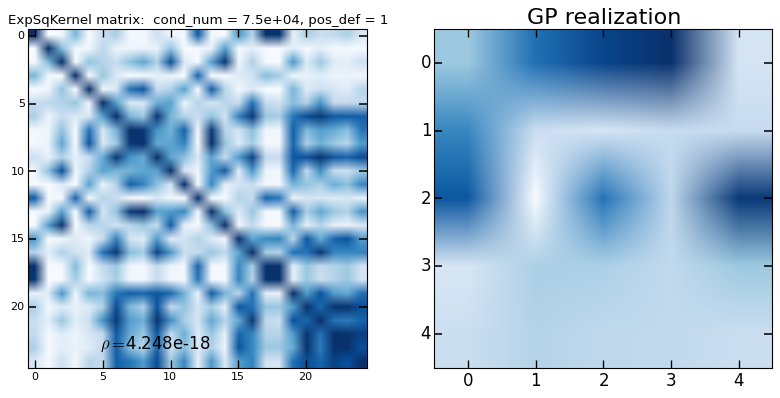

In [23]:
interact(plot_ExpSquaredKernel, inv_lambda=(0.1, 1.5, 0.1),
         l_sq = (0.1, 10, 0.01), log_white_noise=(-8, -1, 1), grid_spacing=(1, 5, 1))

for ExpSquaredKernel it seems like the $l_sq > grid_spacing$ gives large condition number 

http://homepages.inf.ed.ac.uk/amos/toeplitzres.html


In [45]:
def initialize_GP_and_plot_deriv_kernels(inv_lambda, l_sq, log_white_noise, grid, spacing):     
    GPs = OrderedDict({})
    nside = 5
    if grid: 
        coords = np.array([[x, y] 
                           for x in np.arange(0, spacing * (nside + 2), nside)
                           for y in np.arange(0, spacing * (nside + 2), nside)]) 
    else:
        coords = np.random.rand(nside ** 2, 2)
        # coords = np.array([[x, 4] for x in np.linspace(0, 1, nside)])
   
    white_noise = 10. ** log_white_noise
    
    i = 0 
    plt.figure(figsize=(10, 10))
    for k, v in Kernels.iteritems():
        
        GPs[k] = george.GP(inv_lambda * v([l_sq, l_sq], ndim=2))
        sample_mtx = GPs[k].get_matrix(coords) 
        if grid: 
            sample_mtx += np.eye(coords.shape[0]) * white_noise
        else:
            sample_mtx += np.eye(coords.shape[0]) * white_noise
        # sample_mtx /= inv_lambda
        
        pos_def = np.linalg.slogdet(sample_mtx)[0]
        cond_num = np.linalg.cond(sample_mtx)
        # print(sample_mtx)
        
        #sample_mtx *= inv_lambda
        
        # if pos_def == 1.:
        #    color = 'b'  # blue means positive definite matrix
        #else:
        #    color = 'r'
        
        # print(sample_mtx)
        plt.subplot(3, 3, subplot_no[i])
        # plt.plot(range(coords.shape[0]), sample_mtx[:, 4], 'x-',
        #         color=color, mew=2)
        if pos_def:
            cmap = plt.cm.Blues
        else:
            cmap = plt.cm.Reds
        plt.imshow(sample_mtx, cmap=cmap)
        
        # plt.ylim(0, 4)
        plt.figtext(.2, .2, 
                    r"$\rho = ${0:.3e}".format(np.exp(-4 / l_sq)),
                    fontsize=12)
        plt.yticks(fontsize='small')
        plt.xticks(fontsize='small')
        
        plt.title(titles[i] + 
                  ", cond_num = {0:.2g}".format(cond_num),
                  fontsize=10) #titles[i])
        
        i += 1
    plt.show()
    

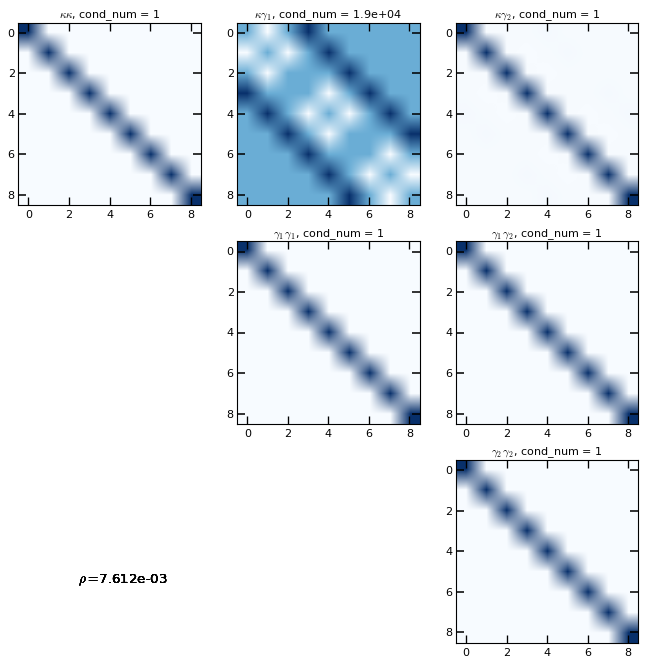

In [46]:
interact(initialize_GP_and_plot_deriv_kernels, inv_lambda=(0.1, 1.5, 0.1),
         l_sq = (0.1, 1.5, 0.01), log_white_noise=(-8, 1, 1), grid=(0, 1, 1), spacing=(1, 5, 1))

In [33]:
def initialize_GP_and_plot_Schur_com_matrices(inv_lambda, l_sq):     
    GPs = OrderedDict({})
    coords = np.array([[1, i] for i in np.linspace(0, 1, 10)])
    
    i = 0
    # plt.figure(figsize=(10, 10))
    for k, v in Kernels.iteritems():
        GPs[k] = george.GP(inv_lambda * v([l_sq, l_sq], ndim=2))
    
    # Compute the Schur complement
    Sigmas = OrderedDict({})
    fig = plt.figure()
    Sigmas["KappaKappa"] = \
        np.matrix(GPs["KappaKappa"].get_matrix(coords))
    Sigmas["KappaGamma1"] = \
        np.matrix(GPs["KappaGamma1"].get_matrix(coords))
    Sigmas["Gamma1Gamma1"] = \
        np.matrix(GPs["Gamma1Gamma1"].get_matrix(coords))
    sec_term = np.dot(Sigmas["KappaGamma1"], 
                      np.dot(np.linalg.inv(Sigmas["Gamma1Gamma1"]), 
                             Sigmas["KappaGamma1"]))
    Schur_com = Sigmas["KappaKappa"] - sec_term
    Schur_pos_def = np.linalg.slogdet(Schur_com)[0]
    if Schur_pos_def == 1.:
        color = 'blue'
    else:
        color = 'red'

    
    # print(sample_mtx)
    i = 0
    for k, v in Sigmas.iteritems():
        plt.subplot(2, 2, i + 1)
        plt.plot(range(coords.shape[0]), v[:, 4], 'x-',
                 color=color, mew=2)
        plt.ylim(0, 7)
        plt.yticks(fontsize='small')
        plt.xticks(fontsize='small')
        plt.title(k, fontsize=15)     
        i += 1
        
    plt.subplot(2, 2, 4)
    plt.title("Schur complement")
    plt.plot(range(Schur_com.shape[0]), Schur_com[:, 4], 'x-',
                 color=color, mew=2)
    plt.figtext(.2, .8, 
                r"$\rho = ${0:.2e}".format(np.exp(-4 / l_sq)),
                fontsize=15)
    #plt.ylabel("Schur Cov matrix [i, 4]")

    plt.yticks(fontsize='small')
    plt.xticks(fontsize='small')

<function __main__.initialize_GP_and_plot_Schur_com_matrices>

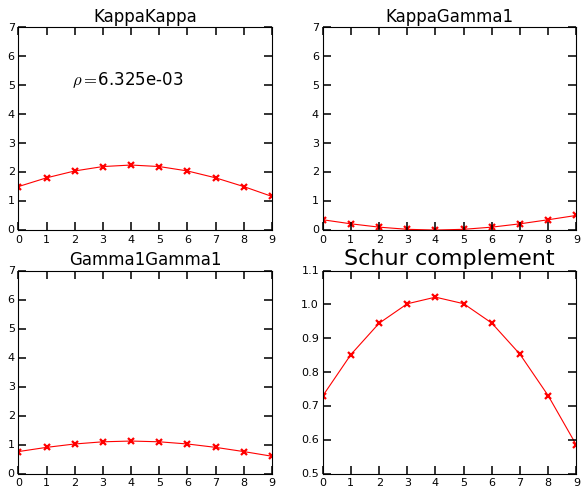

In [34]:
interact(initialize_GP_and_plot_Schur_com_matrices, 
         inv_lambda=(0.1, 1.5, 0.1),
         l_sq = (0.1, 1.5, 0.01))

Schur complement matrix may not be positive definite starting 
from $l^2 > 0.54$

In [39]:
def initialize_GP_and_plot_Schur_com(inv_lambda, l_sq):     
    GPs = OrderedDict({})
    coords = np.array([[1, i] for i in np.linspace(0, 1, 10)])
    
    i = 0
    # plt.figure(figsize=(10, 10))
    for k, v in Kernels.iteritems():
        GPs[k] = george.GP(inv_lambda * v([l_sq, l_sq], ndim=2))
    
    # Compute the Schur complement
    fig = plt.figure()
    sigma_KK = np.matrix(GPs["KappaKappa"].get_matrix(coords))
    sigma_KG = np.matrix(GPs["KappaGamma1"].get_matrix(coords))
    sigma_GG = np.matrix(GPs["Gamma1Gamma1"].get_matrix(coords))
    sec_term = np.dot(sigma_KG, np.dot(np.linalg.inv(sigma_GG), sigma_KG))
    Schur_com = sigma_KK - sec_term
    Schur_pos_def = np.linalg.slogdet(Schur_com)[0]
    if Schur_pos_def == 1.:
        color = 'blue'
    else:
        color = 'red'
    plt.clf()
    # plt.figure(figsize=(8, 6))
    plt.title("Schur complement")
    plt.plot(range(Schur_com.shape[0]), Schur_com[:, 4], 'x-',
                 color=color, mew=2)
    plt.figtext(.45, .5, 
                    r"$\rho = ${0:.2e}".format(np.exp(-4 / l_sq)),
                    fontsize=20)
    plt.ylim(0, 5.)
    plt.ylabel("Schur Cov matrix [i, 4]")
    plt.xlabel("index i")

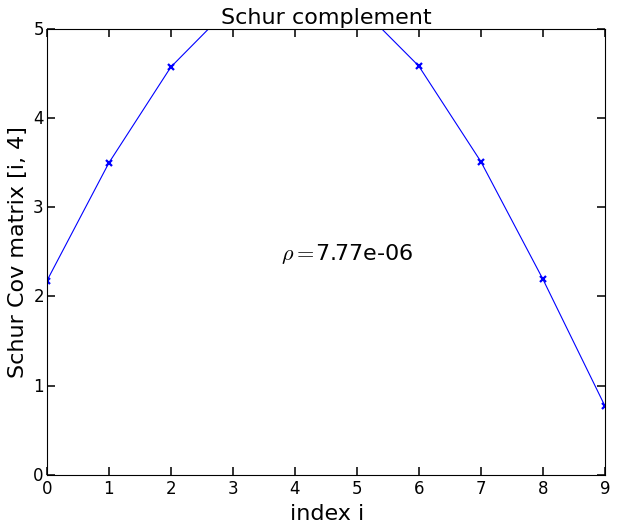

In [40]:
interact(initialize_GP_and_plot_Schur_com, inv_lambda=(0.1, 1.5, 0.1),
         l_sq = (0.1, 1.5, 0.01))